In [1]:
import torch
import pandas as pd
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px

from proc_1_representation import phoneme_representations
from figure_2_representation import figure_adjustments_trace
from data import read_config, CollateItems
from main import setup_pretraining
import soundfile as sf

In [2]:
datapath = './data/'
num_workers = 1
is_cpu = True
sfreq = 100
num_smooth = 3
df_words = pd.read_csv('data/words.csv',index_col=0)
df_phonemes = pd.read_csv('data/phonemes.csv',index_col=0)

In [3]:
config_path = f'experiments/commonvoice_fren_phonemes_words.cfg'

In [4]:
# The training/validation/test data can be specified in a text file as in the following
example_manifest = 'sentences.txt' # Sentences generated with Google TTS

with open(op.join(datapath, example_manifest)) as f:
    print(f.read())

en/sentences/sentence_en_C_16khz
fr/sentences/sentence_fr_A_16khz


In [5]:
# Read configuration file
config = read_config(config_path)
# Overwrite config file to use the example sentences
config.pretraining_manifest_train = example_manifest
config.pretraining_manifest_dev = example_manifest
config.pretraining_manifest_test = example_manifest
# Load model and datasets
trainer, train_dataset, valid_dataset, test_dataset = setup_pretraining(
    config, datapath, num_workers, is_cpu
)
words = np.concatenate(test_dataset.Sy_word+[['']])
phonemes = np.concatenate(test_dataset.Sy_phoneme)
trainer.load_checkpoint()
trainer.model.eval()

100%|██████████| 2/2 [00:00<00:00, 18558.87it/s]


ASRSpecNet(
  (feat): Sequential(
    (0): Sequential(
      (0): STFT(fft_length=1024, hop_length=160, win_length=None)(center=True, pad_mode=reflect, normalized=False, onesided=True)
      (1): ComplexNorm(power=2.0)
      (2): ApplyFilterbank()
    )
    (1): AmplitudeToDb()
    (2): SelectMels()
  )
  (convnet): Sequential(
    (0): Conv1d(128, 64, kernel_size=(1,), stride=(1,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
  )
  (ncl2nlc): NCL2NLC()
  (drop): Dropout(p=0

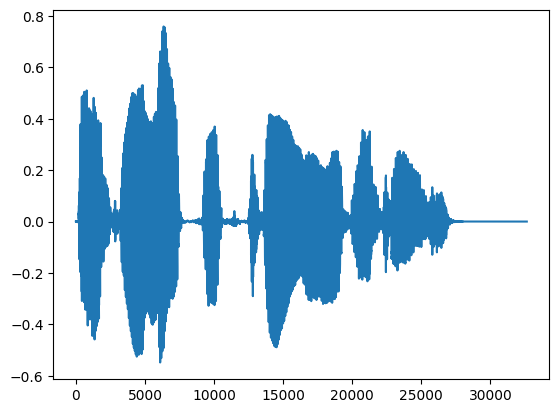

In [6]:
# Plot audio signal of the first (English) sentence
fig, ax = plt.subplots()
ax.plot(test_dataset[0][0])

In [7]:
# Prepare a batch as input to the network
collate_fn = CollateItems()
batch = collate_fn([test_dataset[0],test_dataset[1]])
inputs, targets, lengths = trainer.generate_inputs_and_targets(batch, lang_input=0)

print('Inputs')
print('------')
print('Mel spectrograms')
print('{} audio files, {} mel frequencies, {} frames'.format(*inputs[0].shape))
print('')
print('Language tags')
print(inputs[1].tolist())
print('3: no language tags (the networks in this repository are all trained without language tags)')
print('0: German, 1: English, 2: French')
print('')
print('Number of valid samples per audio file: {}'.format(lengths.tolist()))

Inputs
------
Mel spectrograms
2 audio files, 128 mel frequencies, 207 frames

Language tags
[3, 3]
3: no language tags (the networks in this repository are all trained without language tags)
0: German, 1: English, 2: French

Number of valid samples per audio file: [203, 206]


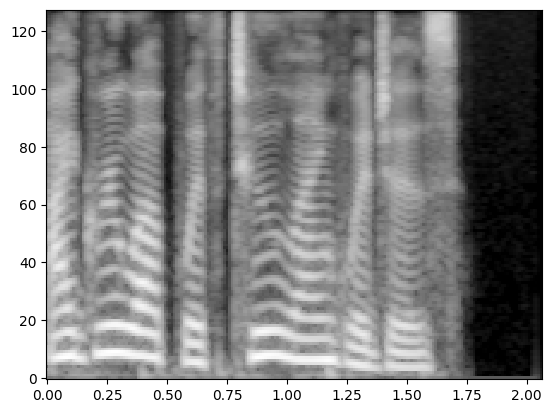

In [8]:
# Plot the Mel spectrogram of the first sentence
L = inputs[0].shape[2]/sfreq
t = np.arange(0,L,1/sfreq)

fig, ax = plt.subplots()
ax.pcolormesh(t,np.arange(128),inputs[0][0],cmap='gray')

In [9]:
# Run through the network
outputs = trainer.model(inputs, lengths)

print('Outputs')
print('------')
print('Phoneme logits:')
print('{} audio files, {} frames, {} phonemes'.format(*outputs[0].shape))
print('')
print('Word logits:')
print('{} audio files, {} frames, {} words'.format(*outputs[1].shape))
print('')
print('Hidden activations phoneme module:')
print('{} audio files, {} frames, {} units'.format(*outputs[4].shape))
print('')
print('Hidden activations word module:')
print('{} audio files, {} frames, {} units'.format(*outputs[4].shape))

Outputs
------
Phoneme logits:
2 audio files, 207 frames, 131 phonemes

Word logits:
2 audio files, 207 frames, 12001 words

Hidden activations phoneme module:
2 audio files, 207 frames, 256 units

Hidden activations word module:
2 audio files, 207 frames, 256 units


In [10]:
# Softmax to compute probabilities from logits
p_phoneme = torch.softmax(outputs[0],2).data.cpu()
p_word = torch.softmax(outputs[1],2).data.cpu()

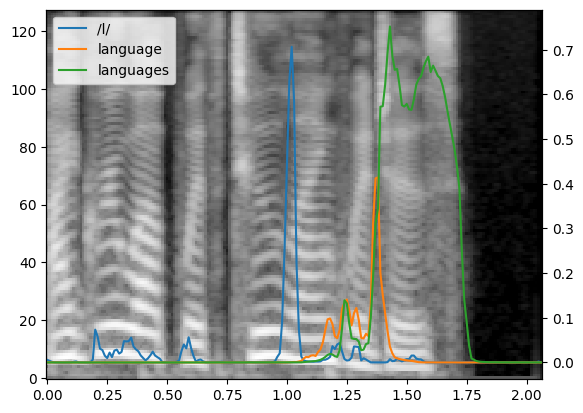

In [11]:
# Plot predictions for the first sentence
index_word1 = np.where(df_words['word']=='language')[0][0]
index_word2 = np.where(df_words['word']=='languages')[0][0]
index_phoneme = np.where(df_phonemes['cmu']=='L')[0][0]

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.pcolormesh(t,np.arange(128),inputs[0][0],cmap='gray')
ax2.plot(t, p_phoneme[0,:,index_phoneme])
ax2.plot(t, p_word[0,:,index_word1])
ax2.plot(t, p_word[0,:,index_word2])
ax2.legend(['/l/','language','languages'])

In [12]:
# Get path to model state dictionary
state_dict_path = op.join(config_path.replace('.cfg',''),'pretraining','model_state.pth')
# Compute PCA of phoneme readout vectors
df, pca, pca_o = phoneme_representations(state_dict_path, ['fr','en'], layer='phone_linear')
# Project hidden activity into PCA space and smooth time-series
dfs = []
for ii in range(2):
    y = pca.transform(outputs[4].data.cpu()[ii])
    for ii in range(y.shape[1]):
        y[:,ii] = np.convolve(
            y[:,ii], np.ones(num_smooth)/num_smooth, mode='same'
        )
    df = pd.DataFrame(dict(
        time = t,
        word = targets[1][0].cpu(),
        phoneme = targets[0][0].cpu(),
    ))
    df[['pca_0','pca_1','pca_2']] = y
    dfs.append(df.iloc[:np.where(targets[0][0]==-1)[0][0]])

In [13]:
# Plot hidden activity in 3d PCA space
fig = go.Figure([go.Scatter3d(
    x=df['pca_0'], y=df['pca_1'], z=df['pca_2'],
    mode='lines'
) for df in dfs])
figure_adjustments_trace(fig)
for ii in range(2):
    fig.data[ii]['line'] = dict(
        width=6, color=df.loc[:175,'time'],
        colorscale=['Reds_r','Blues_r'][ii],
        cmin=0, cmax=1.75
    )
fig